In [ ]:
%%capture
!pip install -Uqq datasets pytorch-lightning tokenizers gensim

Introduction and Setup

In this lesson, we'll learn about a few types of recurrent neural networks (RNNs) and finish by building a text classifier using RNNs. While we will introduce RNNs and explore the concepts behind how they work, we will build multiple RNN types from scratch in a separate lesson. In this module, try to get a feel for what RNNs do, the problems with RNNs, and how to use them in practice.

What is a recurrent neural network?
In most cases, machine learning models cannot directly work with text. Text has to be transformed in to some sort of numerical representation before it can be fed into an ML model. In the past, this was done by counting the frequency of words in a document by using things like CountVectorizer or TfidfVectorizer from scikit-learn.

But what if, instead of creating a large document-term matrix, we could consider each word in the context of the words that came before it? RNNs treat text as a sequence, and consider each word in the context of the words that came before. Each word has a representation (word vector), that is considered along with a representation of the words the model has seen previously, also called a state.

In this module, get a feeling for how RNNs work, and finish by building a text classifier using recurrent neural networks.

Setup
We'll use a new tool in this lesson - the datasets library. We'll use it to load a canonical NLP dataset for text classification and perform some preprocessing on that dataset.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

import tokenizers
from tokenizers import pre_tokenizers, processors, normalizers

import pytorch_lightning as pl
import torchmetrics as metrics

from IPython.display import YouTubeVideo, display
SIZE = {'width':1000, 'height': 600}

Data Preparation

Later on in this module, we'll be using the emotion dataset. From the dataset's documentation:

Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise.

In this lesson, we'll be preparing a Tokenizer to use in our training loop. If any of these steps are unfamiliar, please review the module on preparing raw data for NLP.

In the code block below, we load the dataset and create a lookup for the class names.

In [ ]:
dataset = load_dataset("SetFit/emotion")
class_names = set(dataset['train']['label_text'])
class_lookup = {i:c for i, c in enumerate(class_names)}
class_lookup

Repo card metadata block was not found. Setting CardData to empty.


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

{0: 'surprise', 1: 'joy', 2: 'fear', 3: 'love', 4: 'anger', 5: 'sadness'}

Let's split the data into train and test sets.

In [ ]:
# Split the data into train and test
train = dataset['train']
valid = dataset['test']
len(train), len(valid)

(16000, 2000)

In [ ]:
# What does the data look like?
train[0]

{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}

Let's instantiate and train our tokenizer.

In [ ]:
tokenizer = tokenizers.Tokenizer(tokenizers.models.WordLevel(unk_token='[UNK]'))
tokenizer.normalizer = normalizers.Sequence([normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()])
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

In [ ]:
def train_text_gen():
    for item in train:
        yield item['text']

In [ ]:
trainer = tokenizers.trainers.WordLevelTrainer(vocab_size=30000, special_tokens=['[PAD]', '[UNK]'])

In [ ]:
tokenizer.train_from_iterator(train_text_gen(), trainer)

In [ ]:
tokenizer.enable_padding()

In this lesson we set up for working with RNNs by preparing a text dataset and a tokenzer to numericalize the dataset. None of these concepts should be new, but if you need a refresher please see the previous module.

Embeddings and word vectors

So far, we've done a lot of work preparing data for use in a recurrent model. At this point, you might be asking yourself how we feed a bunch of integers into a model. We do this using a technique called embedding, which we briefly reviewed earlier in the course. Embeddings are a technique to transform sparse categorical data into a dense vector.

In this lesson, we'll create an embedding layer and explore some pre-trained word embeddings to get a feel for how individual words are represented in deep learning.

What is an embedding?
First let's consider a small batch of data. In the cell below, we take two text items and encode them using the tokenizer we trained in the previous lesson.

In [ ]:
text = train[18:20]['text']
ids = torch.tensor([e.ids for e in tokenizer.encode_batch(text)])

print(f'Shape of ids: {ids.shape}')

for t, i in zip(text, ids):
    print(f'''
Text: {t}
IDs:  {i}
''')

Shape of ids: torch.Size([2, 23])

Text: i started feeling sentimental about dolls i had as a child and so began a collection of vintage barbie dolls from the sixties
IDs:  tensor([    2,   198,     8,   898,    27,  5803,     2,    57,    29,     7,
          379,     4,    15,   569,     7,  2018,    10,  2269,  5405,  5803,
           60,     6, 13681])


Text: i now feel compromised and skeptical of the value of every unit of work i put in
IDs:  tensor([   2,   58,    3, 3609,    4,  899,   10,    6, 2110,   10,  147, 4126,
          10,  124,    2,  248,   12,    0,    0,    0,    0,    0,    0])



We see that each token is represented by an ID. We want each token to be represented by a vector. Let's use nn.Embedding to accomplish this. There are two main parameters that are important. First, num_embeddings is the number of word representations we want to learn. Usually, this is just the size of your vocabulary. The other hyperparameter is embedding_dim. This is the size of the vector you want to output. We will also pass the padding_idx in our vocabulary to indicate which token id corresponds to a padding token.

In this example, we'll use tokenizer.get_vocab_size() to determine the number of embeddings, and arbitrarily chose 128 as our embedding_dim.

In [ ]:
emb_layer = nn.Embedding(num_embeddings=tokenizer.get_vocab_size(), embedding_dim=128, padding_idx=0)

Next, let's pass our ids through this layer and observe the shape. We can see that the output shape is 2 x 23 x 128. This makes sense becuse are batch has 2 items in it, the length of the longest sequence is 23 tokens, and our embedding_dim is 128.

In [ ]:
emb_layer(ids).shape

torch.Size([2, 23, 128])

If you recall, the nn.Embedding layer is very similar to an nn.Linear layer, but you asume the input is sparse and categorical. By sparse and categorical, we mean that it's a large vector with a single value in it. If we were using a nn.Linear layer, we'd have to create a large sparse vector and then multiply it by the weights matrix to obtain each encoded word. nn.Embedding improves on this by just looking up the values at the index of the word, instead of doing a large matrix multiplication to obtain the same result.

Fun with word vectors
In the emb_layer we created in the previous lesson, each word will be represented by a vector of size 128. Let's look at the output below.

In [ ]:
emb_layer(ids)[0][0]

tensor([-0.4282, -0.1558, -0.1193,  1.2723, -0.0159,  0.2761,  0.6252, -0.1881,
         0.1194,  0.0611,  1.9013, -1.3123, -0.1868,  0.8267,  0.1850, -1.2071,
        -0.0090,  0.5415,  0.3201,  1.1352, -0.9570,  0.1245,  1.0960, -0.2147,
         0.7521, -0.7929,  0.3966, -0.4497,  1.6362, -0.2288,  0.8279,  1.8932,
         0.5201,  0.5799, -0.2688,  0.6325,  0.4000,  1.8162, -1.3668, -0.9936,
        -0.2611,  1.6098, -0.2047, -0.3801, -0.3722,  2.4498,  0.4764, -2.0473,
         0.6274,  0.8512,  0.3575, -0.4488, -0.9561, -0.3240, -2.1600,  1.0265,
        -0.5858, -0.3774, -0.7670, -2.3694, -0.8476,  1.6567, -0.4559, -0.7870,
        -0.2254,  0.2910,  1.0379, -2.5355,  1.0370, -0.5395,  2.5129,  1.3177,
         0.4741, -0.9537, -1.3965,  0.3275, -2.1132,  1.4536, -1.2112,  1.5715,
        -0.0977,  0.4428, -0.2027, -1.6056,  1.4786,  0.2016, -1.3621,  0.4343,
         1.5311,  0.0053, -1.3946, -0.8540,  1.3714,  0.5114, -0.6357,  0.2733,
         1.2531,  1.1255, -0.5111,  0.26

In the layer we created, the parameters are untrained. Once when parameters are trained, these abstract representations of words become useful. There are a number of techniques including GLoVe and word2vec specifically used for training these word embeddings.

Since training word embeddings only is a relatively outdated technique, we won't cover that in too much detail in this course. However, understanding what word embeddings represent is a useful foundation. There are a few key points that we can learn from older work training word embeddings:

Words can be represented in a semantic space using word embeddings. For example, if a word embedding model were trained on data from an unbiased world, the vector for the word "king" minus the vector for the word "man" plus the vector for the word "woman" should be very close to the vector for the word "queen."
You can train word embeddings using self-supervised learning. In this field, there are some really creative techniques like skip-gram and CBOW that allow you to learn useful parameters from text data without having any labels! We'll apply more self-supervised learning in a later module.
Word vectors are trained such that the distance between word vectors that appear more frequently in the context of the training data is more smaller. For example, the word "quarterback" and "endzone" appear more frequently together than "quarterback" and "puck," so the distance between the word vectors for "quarterback" and "endzone" would be smaller than the distance between "quarterback" and "puck." This is because "quarterback" and "endzone" are both words related to football, and occur frequently in the same context. Alternately, "puck" is is related to hockey and wouldn't occur in the context of "quarterback" or "endzone" often.

To get a feel for how words can be represented in deep learning, please check out the Tenaorflow embedding projector. This represents 200-dimensional word vectors in a 3D point plot.

For a great walkthrough of word vectors, the intuition behind them, and how they're trained, please read this excellent blog post by Jay Alammar. Below, we replicate one of the results on the blog post where "king" - "man" + "woman" = "queen."

In [ ]:
import gensim.downloader

In [ ]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
glove_vectors.most_similar(positive=['king','woman'], negative=['man'])

[('queen', 0.7698540687561035),
 ('monarch', 0.6843381524085999),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534157752991),
 ('prince', 0.6517034769058228),
 ('elizabeth', 0.6464517712593079),
 ('mother', 0.631171703338623),
 ('emperor', 0.6106470823287964),
 ('wife', 0.6098655462265015)]

# Exercise 15.1 - Bias in Language Models

<!-- startquestion -->

Language models are trained on text data that comes from different places.
One of the more convenient places to collect this text data is from the internet, where text content can contain infomration that is incorrect or even harmful.
This results in language models that learn from the context of data they're trained on.
Below, we see an example that examines the cosine distnace between the words "white" and "black" and a number of other words with negative or positive connotations.
We can see that the distance from the word "white" is greater than the distance from the word "black" in the negative cases, yet smaller in the positive case.
The downstream affect is that a model using these embeddings might make decisions differently based on the race, gender, sexual orientation, or other aspect of a person.

In [ ]:
word1 = 'white'
word2 = 'black'
for word3 in ['poor', 'uneducated', 'gang', 'leader']:
    print(f'Word: {word3}, Distance from "{word1}": {glove_vectors.distance(word3, word1):.04f}, Distance from "{word2}": {glove_vectors.distance(word3, word2):.04f}')

Word: poor, Distance from "white": 0.5592, Distance from "black": 0.4923
Word: uneducated, Distance from "white": 0.8553, Distance from "black": 0.7420
Word: gang, Distance from "white": 0.6644, Distance from "black": 0.5904
Word: leader, Distance from "white": 0.5818, Distance from "black": 0.6444


In [ ]:
word1 = 'man'
word2 = 'woman'
for word3 in ['child','america','jacket']: # <-- Enter your words here <--
    print(f'Word: {word3}, Distance from "{word1}": {glove_vectors.distance(word3, word1):.04f}, Distance from "{word2}": {glove_vectors.distance(word3, word2):.04f}')

Word: child, Distance from "man": 0.3317, Distance from "woman": 0.2398
Word: america, Distance from "man": 0.5200, Distance from "woman": 0.5788
Word: jacket, Distance from "man": 0.5982, Distance from "woman": 0.6339


What is a recurrent neural network?
In most cases, machine learning models cannot directly work with text. Text has to be transformed in to some sort of numerical representation before it can be fed into an ML model. In the past, this was done by counting the frequency of words in a document by using things like CountVectorizer or TfidfVectorizer from scikit-learn.

But what if, instead of creating a large document-term matrix, we could consider each word in the context of the words that came before it? This is how RNNs model text as a sequence.

Over the next few lessons, we'll get a feel for how RNNs function. To get started, please complete the following exercise.

# Exercise 15.2

In this exercise, watch the video below and see the [related blog post](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9) (Michael Phi, 2018).
Then, please complete the quiz following this lesson.

<!-- startquestion -->

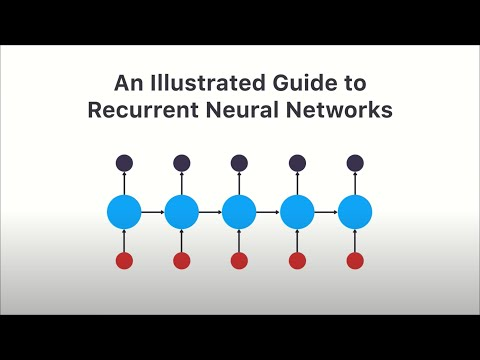

In [ ]:
vid = YouTubeVideo('LHXXI4-IEns', **SIZE)
display(vid)

From feedforward NNs to RNNs

In this lesson, we'll work with our previously-encoded batch of 2 items of text, and pass them through the embedding layer we previously created. Then, we'll compare what we get when we pass the same data through a recurrent neural network (RNN) and conceptualize what happened. If you want the nitty gritty details on how RNNs work internally, there will be a module dedicated to building them from scratch.

First, let's review our batch of texts. We have two tweets from the emotion dataset below.

In [ ]:
text

['i started feeling sentimental about dolls i had as a child and so began a collection of vintage barbie dolls from the sixties',
 'i now feel compromised and skeptical of the value of every unit of work i put in']

In the cell below, we have encoded those tweets using our tokenizer in a previous lesson. Notice that the shorter sentence is padded with zeros.

In [ ]:
ids

tensor([[    2,   198,     8,   898,    27,  5803,     2,    57,    29,     7,
           379,     4,    15,   569,     7,  2018,    10,  2269,  5405,  5803,
            60,     6, 13681],
        [    2,    58,     3,  3609,     4,   899,    10,     6,  2110,    10,
           147,  4126,    10,   124,     2,   248,    12,     0,     0,     0,
             0,     0,     0]])

Let's use our emb_layer to encode these ids into word vectors.

In [ ]:
word_embs = emb_layer(ids)
word_embs.shape

torch.Size([2, 23, 128])

Notice that our embedded batch now has a shape of 2 x x 128 (batch size, length of longest tweet in the batch, embedding dim). Now that we have these encoded, let's pass them through the Linear layer and observe the outputs. Since the weights are the same dimensionality as the emb_dim, the outputs should be the same shape as the inputs.

In [ ]:
lin = nn.Linear(128, 128)

Now tlet's take a look at the shape of the outputs. This is the same shape as the word_embs, since in_features = out_features in our nn.Linear layer.

In [ ]:
lin_outputs = lin(word_embs)
lin_outputs.shape, word_embs.shape

(torch.Size([2, 23, 128]), torch.Size([2, 23, 128]))

When we passed our embeddings through the linear layer, we performed a linear transformation on each word independently. To perform a downstream task, we'd still have to aggregate all of this data in some way.

This is where RNNs come into play. RNNs are actually just two nn.Linear layers - one receives the input of of the current word, and the other receives the output of the last word, also called the hidden state. Then, the outputs of these two small networks are summed and then the hyperbolic tangent (tanh) of the sum is the new output, which the following word would receive as the hidden state. Let's look at the math.

[Math Error]

First, notice that there are two [Math Error] symbols and two [Math Error] symbols. This means we just have two linear layers, where:

[Math Error] is the weights matrix from the input to hidden state
[Math Error] is the bias term from the input to hidden state
[Math Error] is the weights matrix from previous hidden state to the current hidden state
[Math Error] is the bias term from the previous hidden state to the current hidden state
[Math Error] is a dense vector representing a single word
[Math Error] are the outputs from the previous word. If this happens to be the first word in a sequence, the valuds of this vector are 0.
Below is an illustration of an RNN. On the left, there is an "unrolled" RNN, where we visualize every time step alone. Note that the inputs and hidden states at each time step share the same parameters. On the right, there is a different view of an RNN, where the hidden state of the previous word is the input and the current hidden state is the output.

If this is still confusing, we'll code it from scratch in a different lesson. For now, let's pass our embeddings through an RNN to see what we get! In the block of code below, we instantiate an RNN, pass our embedded batch through the layer, then observe the shape of the outputs. We can see that since the input_size and hidden_size are the same, the output for each word should be the same size as the input. However, we also get the hidden_states, which is the output of the final word in each sequence.

In [ ]:
rnn = nn.RNN(input_size=128, hidden_size=128, num_layers=1, batch_first=True)

In [ ]:
rnn_outputs, hidden_states = rnn(word_embs)
rnn_outputs.shape, hidden_states.shape

(torch.Size([2, 23, 128]), torch.Size([1, 2, 128]))

Let's check that the hidden_states are the same as the final outputs of the rnn.

In [ ]:
assert (rnn_outputs.permute(1, 0, 2)[-1] == hidden_states).all()

Finally, let's perform a sanity check. If we set [Math Error] and [Math Error] to 0, and set [Math Error] and [Math Error] to the weights and bias of our lin layer, the rnn_outputs should be the same as lin_outputs.tanh().

In [ ]:
%%capture
rnn.weight_hh_l0.data.zero_() # set Whh to 0
rnn.bias_hh_l0.data.zero_() # set bhh to 0
rnn.weight_ih_l0.data.copy_(lin.weight.data) # set Wih to the weights of the linear layer
rnn.bias_ih_l0.data.copy_(lin.bias.data) # set bih to the bias of the linear layer

In [ ]:
# obtain the rnn outputs and hidden state after modifying weights and biases
rnn_outputs, hidden_states = rnn(word_embs)

In [ ]:
# check that lin_outputs.tanh() are the same as the rnn outputs
assert (lin_outputs.tanh() == rnn_outputs).all()

You may have also noticed that nn.RNN has a num_layers parameter. This allows you to stack multiple RNNs on top of each other. In this case, the rnn_outputs are passed into another RNN that works with each output sequentially, as shown in the image below. Changing the num_layers parameter will make your RNN deeper.



When using stacked RNNs in torch (where num_layers > 0), all RNN classes (including LSTM and GRU) will return the hidden states for all layers, not just the final layer. This is something to keep in mind when building networks.

In [ ]:
for n_layers in range(1, 6):
    rnn = nn.RNN(input_size=128, hidden_size=128, num_layers=n_layers, batch_first=True)
    rnn_outputs, hidden_states = rnn(word_embs)
    print(f"Number of RNN layers: {n_layers}, hidden state shape: {hidden_states.shape}")

Number of RNN layers: 1, hidden state shape: torch.Size([1, 2, 128])
Number of RNN layers: 2, hidden state shape: torch.Size([2, 2, 128])
Number of RNN layers: 3, hidden state shape: torch.Size([3, 2, 128])
Number of RNN layers: 4, hidden state shape: torch.Size([4, 2, 128])
Number of RNN layers: 5, hidden state shape: torch.Size([5, 2, 128])


When performing tasks like classification of a sentence, the last hidden state is generally used as a representation of the entire document. Some practitioners like to use the individual outputs as well - you can apply techniques like 1-d convolution or pooling to represent the sentence as a vector. FastAI has a convenient text_classifier_learner function that we'll explore later that uses pooled RNN outputs instead of the final state to perform classificaiton. However in this module, we will use the final hidden state. If you are training RNNs from scratch, it may be worth your time to experiment with how to combine the outputs of the network to generate inferences.

In this lesson, we were introduced to RNNs, which allow elements in a sequence to be represented in the context of the elements that came before. In the next few lessons, we will build on this knowledge to highlight some problems with vanilla RNNs and some different solutions.

The Gated Recurrent Unit (GRU)

We'll start with the GRU since it's relatively simple. This book chapter from d2l.ai does a great job of describing the motivations behind the GRU. We will summarize this chapter here, and examine the inputs and outputs of a GRU.

Just like vanilla RNNs, a GRU cell accepts the hidden state from the previous word, and a representation of the current word. These two inputs are concatenated, so if [Math Error] and [Math Error] are both tensors of shape (batch_size, seq_length, 128), the concatenated tensor will be (batch_size, seq_length, 256). This new tensor is fed into two simple feedforward (nn.Linear) networks with a sigmoid activation, meaning the outputs are between 0 and 1.

The first gate is the reset gate. The network that outputs the reset values [Math Error] learns how much of the previous state it wants to rememer, given the previous state and the current time step.

The second gate is the update gate. This network outputs the update values [Math Error], and learns how much the new state is a copy of the old state.

The next step is to generate a candidate hidden state [Math Error], shown in the figure below. To do this, we multiply [Math Error] by the previous hidden state [Math Error] and pass it through a tanh activation function. If the values in [Math Error] are all 1.0, the candidate hidden state will be the same as [Math Error]. Conversely, if the values in [Math Error] are all 0, the previous hidden state will be completely "forgotten."

Finally, we want to calculate the new hidden state [Math Error], which will be the state passed into the cell at the next time step. This new state will be a linear combination of the previous hidden state [Math Error] and the candidate hidden state [Math Error]. The network that generates [Math Error] can be thought of as a nn.Linear layer with tanh activation, and is given by:

[Math Error]

Then, we take a linear combination of [Math Error] and \(\tilde{H}t\) to generate our new hidden state. Recall that the values of [Math Error] are all between 0 and 1, and tells us at each feature how much \(H{t-1}\) and [Math Error] we want. [Math Error] is given by:

[Math Error]

All this means is that we're taking some fraction of the previous hidden state and the candidate hidden state and summing them together. The update gate learns, given a the current word/timestep, whether to more heavily favor previous information ([Math Error]) or new information ([Math Error]).

While the implementation of GRU may seem complicated, its usage is straightforward. Let's pass our embedded batch through a GRU. Note that although the layer is more complex, the shape of the inputs and outputs remains the same.

In [ ]:
gru = nn.GRU(input_size=128, hidden_size=128, num_layers=1, batch_first=True)

In [ ]:
gru_outputs, gru_hidden_states = gru(word_embs)
gru_outputs.shape, gru_hidden_states.shape

(torch.Size([2, 23, 128]), torch.Size([1, 2, 128]))

Long Short-Term Memory (LSTM)

Another solution to the vanishing gradient and forgetting problems is the LSTM (long short-term memory) RNN. Although it pre-dates the GRU, it is a bit more complicated. In this lesson, we'll learn the key concepts behind LSTM and implement one.

In the previous lesson, we learned that GRU has 3 sets of parameters - the reset gate, the update gate, and the candidate hidden state. LSTM cells have four sets of parameters - the forget gate [Math Error], the input gate [Math Error], the output gate [Math Error], and the candidate memory [Math Error]. Note that these all have sigmoid activations to squash the outputs between 0 and 1. You can think of each of these gates as its own nn.Linear layer with either a sigmoid or tanh activation. The previous hidden state [Math Error] is concatenated with the current input [Math Error] and passed through each of these networks.

In vanilla RNN and GRU, only the hidden state is passed from one timestep to the next. In LSTM, there are two items - the previous hidden state [Math Error] and a new concept called memory [Math Error]. As shown in the figure below, memory is modified by the outputs of the forget gate, input gate, and candidate memory.

Finally, the memory [Math Error] and the output gate [Math Error] are used to generate the new hidden state for the current time step [Math Error] which is given by:

Now that we've taken a peek inside LSTM networks, let's actually create one. As shown below, when our embedded texts are passed into the LSTM, the outputs for each word, and a tuple of the final hidden state and memory are returned.

In [ ]:
lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)

In [ ]:
lstm_outputs, (lstm_state, lstm_memory) = lstm(emb_layer(ids))
lstm_outputs.shape, lstm_state.shape, lstm_memory.shape

(torch.Size([2, 23, 128]), torch.Size([1, 2, 128]), torch.Size([1, 2, 128]))

Finally, let's perform a sanity check that the final output of the LSTM is the same as the final hidden state.

In [ ]:
assert (lstm_outputs[:, -1, :].squeeze() == lstm_state.squeeze()).all()

Text Classification with RNNs

In this lesson, we'll perform text classification with RNNs. Unlike the previous lessons in this module, we will also train our parameters to perform a text classification task. We will also compare performance on vanilla RNNs, GRU, and LSTM.

Preparing the data
First, we need our train and validation dataloaders. In the cells below, we've provided a default batch size and a class that will serve as our collate_fn.

In [ ]:
BATCH_SIZE = 64

In [ ]:
class TokenizeCollate:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.tokenizer.enable_padding()

    def __call__(self, batch):
        texts = [i['text'] for i in batch]
        inputs = torch.tensor([item.ids for item in self.tokenizer.encode_batch(texts)])
        labels = torch.tensor([i['label'] for i in batch])
        return inputs, labels

collate_fn = TokenizeCollate(tokenizer)

# Exercise 15.3

<!-- startquestion -->

Create the train and validation dataloaders using the `train` and `valid` datasets, `BATCH_SIZE`, and `collate_fn`.

In [ ]:
train_dl = torch.utils.data.DataLoader(train,batch_size=BATCH_SIZE, collate_fn=collate_fn)
valid_dl = torch.utils.data.DataLoader(valid,batch_size=BATCH_SIZE, collate_fn=collate_fn)

Building our model

In the cell below, we used pytorch-lightning to build our model. For ease, each layer including embeddings, our RNN, and the input to the final linear layer all use the same dimensionality.

In [ ]:
class Model(pl.LightningModule):
    def __init__(self, dim_model, n_rnn_layers, n_outputs=len(class_names), vocab_size=tokenizer.get_vocab_size(), pad_idx=0):
        super().__init__()
        # Save parameters
        self.dim_model = dim_model
        self.n_rnn_layers = n_rnn_layers
        self.n_outputs = n_outputs
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx

        # Set up loss
        self.loss = nn.CrossEntropyLoss()

        # Set up metrics
        self.train_acc = metrics.Accuracy(task="multiclass", num_classes=self.n_outputs)
        self.valid_acc = metrics.Accuracy(task="multiclass", num_classes=self.n_outputs)
        self.train_auroc = metrics.AUROC(task="multiclass", num_classes=self.n_outputs)
        self.valid_auroc = metrics.AUROC(task="multiclass", num_classes=self.n_outputs)

        # Build the model
        self.emb = nn.Embedding(self.vocab_size, self.dim_model, padding_idx=self.pad_idx)
        self.rnn = nn.GRU(self.dim_model, self.dim_model, num_layers=self.n_rnn_layers, batch_first=True)
        self.output = nn.Linear(self.dim_model, self.n_outputs)

        self.save_hyperparameters()

    def forward(self, inputs):
        rnn_outputs, hidden_state = self.rnn(self.emb(inputs))
        outputs = self.output(hidden_state.squeeze()[-1])
        return outputs

    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self(x)
        loss = self.loss(yhat, y)
        probas = yhat.softmax(axis=-1)
        preds = probas.argmax(axis=-1).int()
        acc = self.train_acc(y, preds)
        auroc = self.train_auroc(probas, y)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True, on_step=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True, on_step=True)
        self.log('train_auroc', auroc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        yhat = self(x)
        loss = self.loss(yhat, y)
        probas = yhat.softmax(axis=-1)
        preds = probas.argmax(axis=-1).int()
        acc = self.valid_acc(y, preds)
        auroc = self.valid_auroc(probas, y)
        self.log('valid_loss', loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('valid_acc', acc, prog_bar=True, on_epoch=True, on_step=False)
        self.log('valid_auroc', auroc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

Training Setup
In the cell below, we set up our training. In this example, we use early stopping, and a CSV logger. Note that the pl.Trainer has teh argument track_grad_norm=2. When provided, this argument will track the L2-norm of the gradients for each layer, and can be useful for debugging deep learning models. Alternately, if track_grad_norm=1, it will track the L1-norm. We will use this in a later exercise to compare the gradients between different RNN subtypes.

In [ ]:
cbs = [pl.callbacks.EarlyStopping(monitor='valid_loss', patience=2)]
logger = pl.loggers.CSVLogger(save_dir='.', name='GRU', version=0)
trainer = pl.Trainer(accelerator="auto", callbacks=cbs, logger=logger, log_every_n_steps=1)  #He cambiado gpus=1 y track_grad_norm=2, he anadido accelerator="auto"

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Next, let's instantiate and train our model using our trainer.

In [ ]:
model = Model(128, 2)

In [ ]:
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=valid_dl)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params
---------------------------------------------------
0 | loss        | CrossEntropyLoss   | 0     
1 | train_acc   | MulticlassAccuracy | 0     
2 | valid_acc   | MulticlassAccuracy | 0     
3 | train_auroc | MulticlassAUROC    | 0     
4 | valid_auroc | MulticlassAUROC    | 0     
5 | emb         | Embedding          | 1.9 M 
6 | rnn         | GRU                | 198 K 
7 | output      | Linear             | 774   
---------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.585     Total estimated model params size

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:42: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Now that we've trained a model, let's inspect our results. Since our training was logged to a CSV, let's read in the data.

In [ ]:
logs = pd.read_csv('GRU/version_0/metrics.csv')
logs[logs.columns[logs.columns.str.contains('loss|acc|auc')]]

,train_loss_step,train_acc_step,valid_loss,valid_acc,train_loss_epoch,train_acc_epoch
0,1.826405,0.109375,NaN,NaN,NaN,NaN
1,1.809875,0.062500,NaN,NaN,NaN,NaN
2,1.774835,0.187500,NaN,NaN,NaN,NaN
3,1.757721,0.343750,NaN,NaN,NaN,NaN
4,1.740822,0.281250,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2011,0.054472,0.968750,NaN,NaN,NaN,NaN
2012,0.070340,0.937500,NaN,NaN,NaN,NaN
2013,0.074351,0.968750,NaN,NaN,NaN,NaN
2014,NaN,NaN,0.314011,0.8955,NaN,NaN


Before we inspect our results, let's look at the distribution of labels in the validaion dataset. We want to make sure our performance is better than random chance! It looks like if we applied random guessing, the best accuracy we could achieve is about 0.35.

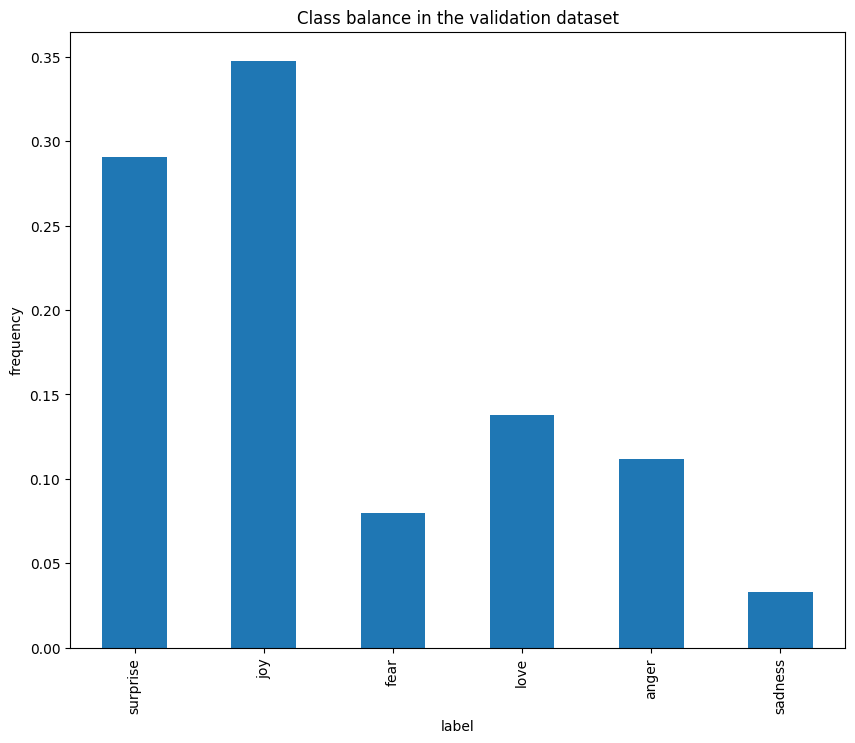

In [ ]:
pd.Series(valid['label']).value_counts(normalize=True).sort_index().plot.bar(figsize=(10,8))
plt.title('Class balance in the validation dataset')
plt.xticks(range(6), class_names)
plt.ylabel('frequency')
plt.xlabel('label')
plt.show()

In the cell below, we take a look at the accuracy and ROC-AUC at our lowest validation loss. We can be pretty confident that we out-performed random chance.

In [ ]:
best_valid_loss = logs.valid_loss.min()
best_valid_acc = logs[logs.valid_loss == best_valid_loss].valid_acc.max()
best_valid_auroc = logs[logs.valid_loss == best_valid_loss].valid_auroc.max()
print(f"""
Best valid loss: {best_valid_loss:.04f}
Accuracy at best valid loss: {best_valid_acc:.04f}
ROC-AUC at best valid loss: {best_valid_auroc:.04f}
""")


Best valid loss: 0.2714
Accuracy at best valid loss: 0.9045
ROC-AUC at best valid loss: 0.9843



Let's plot out some of our metrics for a more detailed model evaluation. In the figure below, we plot the train and validaion loss, accuracy, and ROC-AUC over time. We also plot hte L2-norm of the gradients for some weights matrices of the first two RNN layers over time so we can inspect the size of the gradients during training.

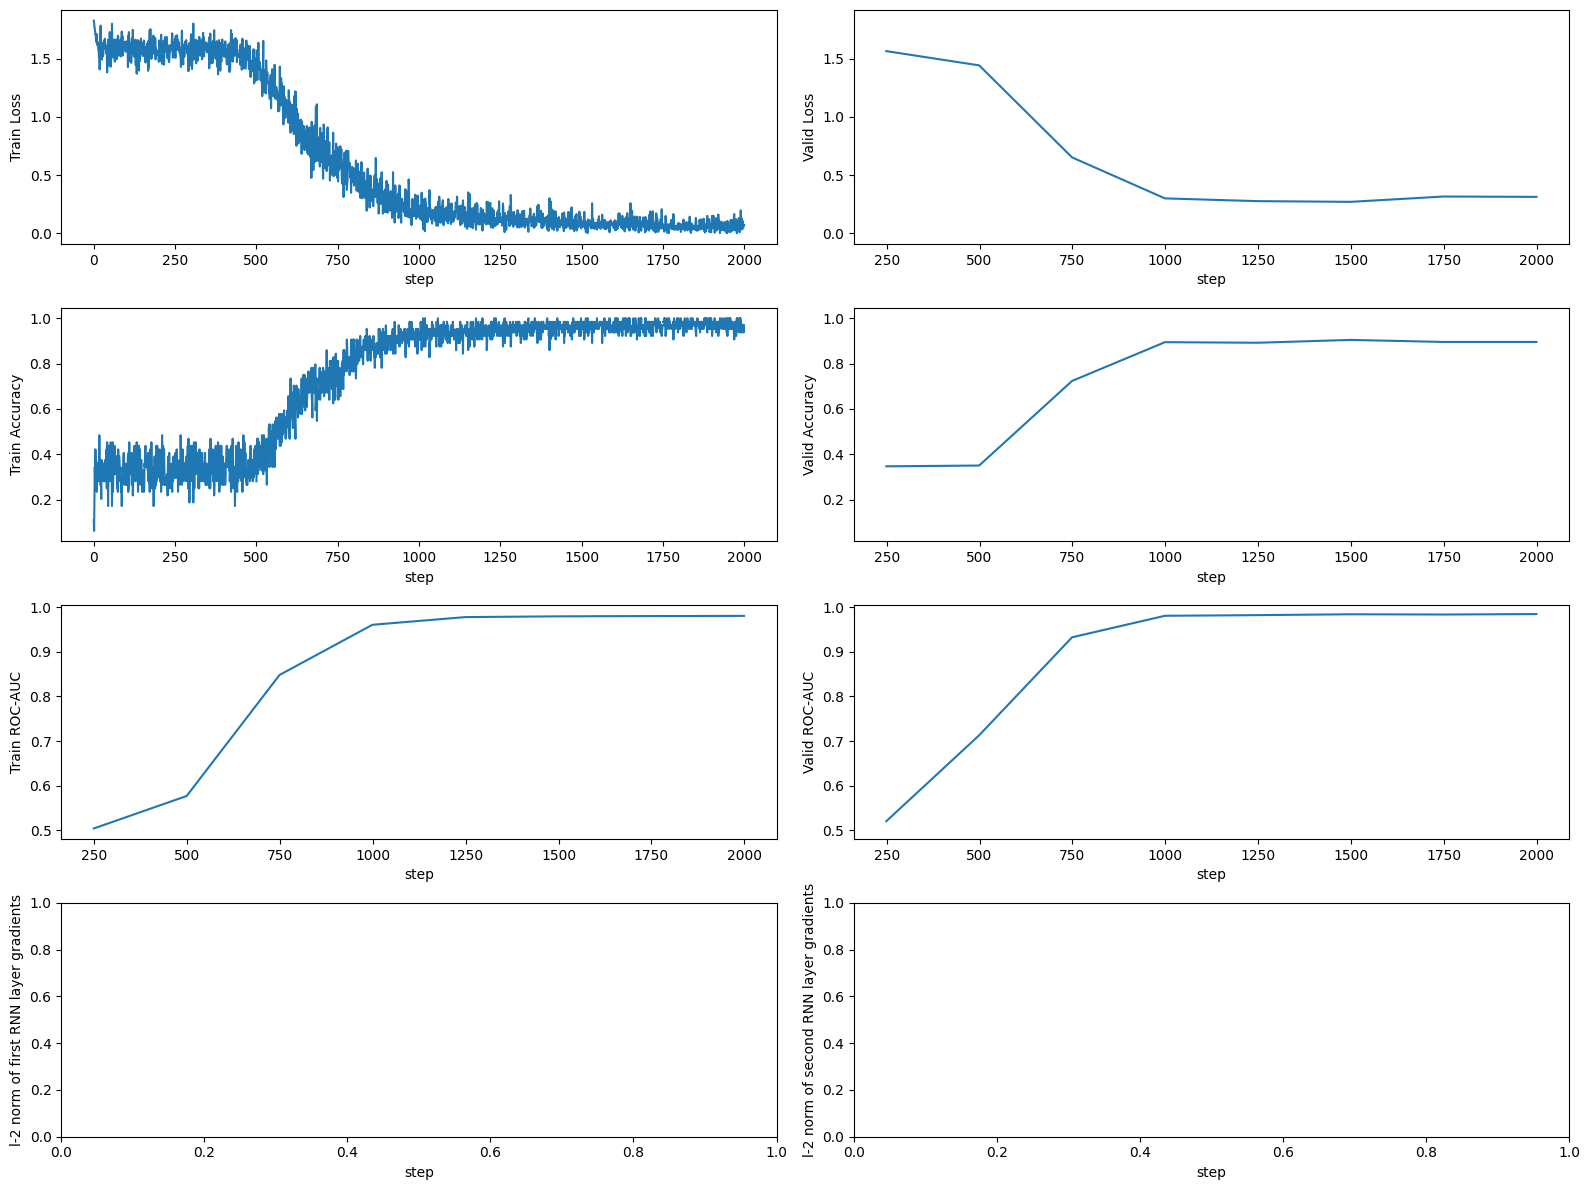

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(16, 12))
logs.set_index('step').train_loss_step.plot(ax=axes[0,0])
axes[0,0].set_ylabel('Train Loss')
logs.set_index('step').valid_loss.dropna().plot(ax=axes[0,1])
axes[0,1].set_ylabel('Valid Loss')
logs.set_index('step').train_acc_step.plot(ax=axes[1,0])
axes[1,0].set_ylabel('Train Accuracy')
logs.set_index('step').valid_acc.dropna().plot(ax=axes[1,1])
axes[1,1].set_ylabel('Valid Accuracy')
axes[0,1].set_ylim(axes[0,0].get_ylim())
axes[1,1].set_ylim(axes[1,0].get_ylim())
logs.set_index('step').train_auroc.dropna().plot(ax=axes[2,0])
axes[2,0].set_ylabel('Train ROC-AUC')
logs.set_index('step').valid_auroc.dropna().plot(ax=axes[2,1])
axes[2,1].set_ylabel('Valid ROC-AUC')
axes[2,1].set_ylim(axes[2,0].get_ylim())
#logs[['grad_2.0_norm/rnn.weight_hh_l0_step', 'grad_2.0_norm/rnn.weight_ih_l0_step']].plot(ax=axes[3,0])    #me da problemas el grad_norm=2
axes[3,0].set_ylabel('l-2 norm of first RNN layer gradients')
axes[3,0].set_xlabel('step')
if model.n_rnn_layers >= 2:
    #logs[['grad_2.0_norm/rnn.weight_ih_l1_step', 'grad_2.0_norm/rnn.weight_hh_l1_step']].plot(ax=axes[3,1])    #me da problemas el grad_norm=2
    axes[3,1].set_ylabel('l-2 norm of second RNN layer gradients')
    axes[3,1].set_xlabel('step')
fig.tight_layout()

# Exercise 15.4

<!-- startquestion -->

In the example above, we trained a GRU network that was able to successfully classify the emotion of tweets with over 90% accuracy on the validaiton dataset.
To complete this exercise, please train a vanilla RNN and a LSTM and report the best validation loss and accuracy.
What do you notice about the vanilla RNN during training?
What haeve you learned about vanilla RNNs that may explain these results?

In [ ]:
# Your code here